In [1]:
# Cell 1: Imports & Hyperparameters
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# Your data directory
DATA_ROOT   = "D:/AIML/data/flower_photos/flower_photos"
IMG_SIZE    = 180    # we’ll resize all images to 180×180
PATCH_SIZE  = 30     # each patch = 30×30 pixels → 6×6 grid → 36 patches
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2
EMBED_DIM   = 64
NUM_HEADS   = 4
MLP_DIM     = 128
NUM_LAYERS  = 4
BATCH_SIZE  = 32
EPOCHS      = 20
AUTOTUNE    = tf.data.AUTOTUNE


In [2]:
# Cell 2: Patch layer + Embedding + Transformer block definitions

class PatchExtractor(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1,1,1,1],
            padding="VALID"
        )
        # reshape to (batch, num_patches, patch_dim)
        patch_dim = patches.shape[-1]
        return tf.reshape(patches, [batch, -1, patch_dim])


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patches, embed_dim):
        super().__init__()
        self.proj   = layers.Dense(embed_dim)
        self.pos_emb = layers.Embedding(input_dim=num_patches, output_dim=embed_dim)
    def call(self, x):
        # x: (batch, num_patches, patch_dim)
        positions = tf.range(start=0, limit=tf.shape(x)[1], delta=1)
        return self.proj(x) + self.pos_emb(positions)


def transformer_encoder(x, embed_dim, num_heads, mlp_dim, dropout=0.1):
    # 1) Multi-head self-attention
    res = x
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
    x = layers.Dropout(dropout)(x)
    x = x + res

    # 2) Feed-forward
    res = x
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Dense(mlp_dim, activation="gelu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(embed_dim)(x)
    x = layers.Dropout(dropout)(x)
    return x + res


In [3]:
# Cell 3: Data loading & preprocessing pipeline
raw_train = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_ROOT,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=None,       # no batching yet
    label_mode="int"
)
raw_val = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_ROOT,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=None,
    label_mode="int"
)

# simple normalize to [0,1]
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = (raw_train
            .map(preprocess, num_parallel_calls=AUTOTUNE)
            .shuffle(1000)
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE))
val_ds = (raw_val
          .map(preprocess, num_parallel_calls=AUTOTUNE)
          .batch(BATCH_SIZE)
          .prefetch(AUTOTUNE))

CLASS_NAMES = raw_train.class_names
NUM_CLASSES = len(CLASS_NAMES)
print("Classes:", CLASS_NAMES)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
Classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [4]:
# Cell 4: Assemble the Vision Transformer model
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# 1) Extract patches
x = PatchExtractor(PATCH_SIZE)(inputs)            # (batch, num_patches, patch_dim)

# 2) Linear embed + positional embed
x = PatchEmbedding(NUM_PATCHES, EMBED_DIM)(x)

# 3) N Transformer blocks
for _ in range(NUM_LAYERS):
    x = transformer_encoder(x, EMBED_DIM, NUM_HEADS, MLP_DIM)

# 4) Classification head
x = layers.LayerNormalization(epsilon=1e-6)(x)
x = layers.GlobalAveragePooling1D()(x)            # pool over the patch dimension
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

vit = keras.Model(inputs, outputs, name="custom_vit")
vit.summary()


Model: "custom_vit"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 patch_extractor (PatchExtr  (None, None, 2700)           0         ['input_1[0][0]']             
 actor)                                                                                           
                                                                                                  
 patch_embedding (PatchEmbe  (None, None, 64)             175168    ['patch_extractor[0][0]']     
 dding)                                                                                           
                                                                                         

In [5]:
# Cell 5: Compile & train
vit.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = vit.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/20
92/92 [==============================] - 19s 108ms/step - loss: 1.7922 - accuracy: 0.2537 - val_loss: 1.4437 - val_accuracy: 0.3624
Epoch 2/20
92/92 [==============================] - 10s 102ms/step - loss: 1.5578 - accuracy: 0.3137 - val_loss: 1.3269 - val_accuracy: 0.4278
Epoch 3/20
92/92 [==============================] - 10s 103ms/step - loss: 1.4310 - accuracy: 0.3644 - val_loss: 1.2823 - val_accuracy: 0.4155
Epoch 4/20
92/92 [==============================] - 12s 120ms/step - loss: 1.3386 - accuracy: 0.4111 - val_loss: 1.2307 - val_accuracy: 0.4837
Epoch 5/20
92/92 [==============================] - 10s 104ms/step - loss: 1.2890 - accuracy: 0.4332 - val_loss: 1.1881 - val_accuracy: 0.4550
Epoch 6/20
92/92 [==============================] - 10s 106ms/step - loss: 1.2408 - accuracy: 0.4567 - val_loss: 1.1882 - val_accuracy: 0.4564
Epoch 7/20
92/92 [==============================] - 11s 112ms/step - loss: 1.2200 - accuracy: 0.4693 - val_loss: 1.1734 - val_accuracy: 0.4755

23/23 [==============================] - 1s 41ms/step - loss: 1.1210 - accuracy: 0.5954
Validation Accuracy: 0.5954
1/1 [==============================] - 0s 456ms/step


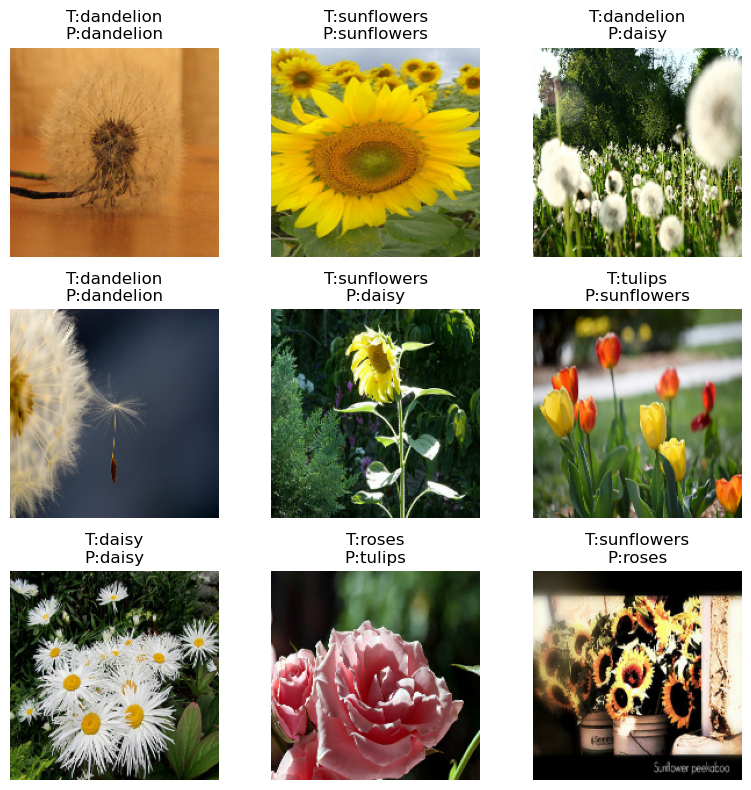

In [6]:
# Cell 6: Evaluate & quick predictions
loss, acc = vit.evaluate(val_ds)
print(f"Validation Accuracy: {acc:.4f}")

# show a few
import matplotlib.pyplot as plt
for imgs, labels in val_ds.take(1):
    preds = vit.predict(imgs)
    pidx  = tf.argmax(preds, axis=1).numpy()
    plt.figure(figsize=(8,8))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(imgs[i].numpy())
        plt.title(f"T:{CLASS_NAMES[labels[i]]}\nP:{CLASS_NAMES[pidx[i]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    break
